In [ ]:
TRACKING_SERVER_HOST = "" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [1]:
import pandas as  pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')

In [28]:
from utils.preprocessing import read, prepare

In [34]:

target = 'median_house_value'
numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
categorical = ['ocean_proximity']

    
    
def run(df_train: pd.DataFrame, df_test: pd.DataFrame, num_trials=100):
    X_train = df_train.drop(columns=target)
    X_test = df_test.drop(columns=target)

    y_train = df_train[target].values
    y_test = df_test[target].values

    best_loss = float('inf')
    best_y_pred = None

    def objective(params):
        nonlocal best_loss, best_y_pred

        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)

        if rmse < best_loss:
            best_loss = rmse
            best_y_pred = y_pred

        return {'loss': rmse, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
        'random_state': 42
    }

    rstate = np.random.default_rng(42)  # for reproducible results
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

    return best_y_pred, y_test



# Read dataframe

In [35]:
raw_housing = read('housing.csv')
raw_housing = raw_housing[raw_housing.ocean_proximity!='ISLAND'] 
raw_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [36]:
raw_housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

* Filling null values

In [37]:
raw_housing['total_bedrooms'] = raw_housing['total_bedrooms'].fillna(raw_housing['total_bedrooms'].median())

In [38]:
raw_housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
Name: count, dtype: int64

# Prepare our dataset

In [54]:
from sklearn.model_selection import train_test_split

raw_train, raw_test= train_test_split(raw_housing, test_size=0.3, random_state=42)

In [55]:
raw_train.shape, raw_test.shape

((14444, 10), (6191, 10))

In [56]:
raw_train.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [50]:
raw_test.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [81]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import RobustScaler
from utils.model_io import dump_pickle, load_pickle

def prepare(df:pd.DataFrame, fit: bool = False, data_path:str='data/preprocess/')->pd.DataFrame:
    "Prepare a raw dataframe, returning a prepare DataFrame"
    
    target = 'median_house_value'
    numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income']
    categorical = ['ocean_proximity']

    if fit:
        
        dv = DictVectorizer()
        scaler = RobustScaler().set_output(transform="pandas")
        df_scaled = scaler.fit_transform(df[numerical])
        
        
        dicts = df[categorical].to_dict(orient='records')
        dv = DictVectorizer()
        ohe = pd.DataFrame(dv.fit_transform(dicts).todense(), columns=dv.feature_names_)
         

        df_prepare = pd.concat([ohe.reset_index(drop=True),df_scaled.reset_index(drop=True),df[target].reset_index(drop=True)], axis=1)
        
        dump_pickle(dv,f'{data_path}/dv.pkl')
        dump_pickle(scaler,f'{data_path}/scaler.pkl')
        return df_prepare

In [82]:
prepare_train = prepare(raw_train,fit=True,data_path='../data/preprocess')
prepare_test = prepare(raw_test,fit=True,data_path='../data/preprocess')


In [84]:
best_y_pred, y_test = run(prepare_train,prepare_train,20)

100%|██████████| 20/20 [00:33<00:00,  1.66s/trial, best loss: 24884.453563370764]


C:\Users\user\AppData\Local\Temp\ipykernel_1724\2894624454.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(best_y_pred, label='prediction')
C:\Users\user\AppData\Local\Temp\ipykernel_1724\2894624454.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, label='actual')


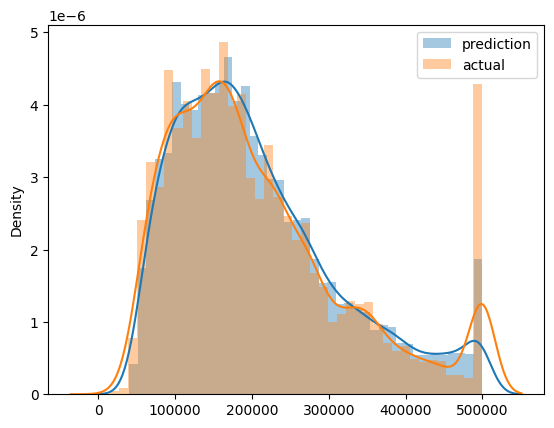

In [85]:
sns.distplot(best_y_pred, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()

In [86]:
best_y_pred, y_test = run(prepare_train,prepare_test,20)


100%|██████████| 20/20 [00:32<00:00,  1.65s/trial, best loss: 58228.989100099694]


C:\Users\user\AppData\Local\Temp\ipykernel_1724\2894624454.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(best_y_pred, label='prediction')
C:\Users\user\AppData\Local\Temp\ipykernel_1724\2894624454.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, label='actual')


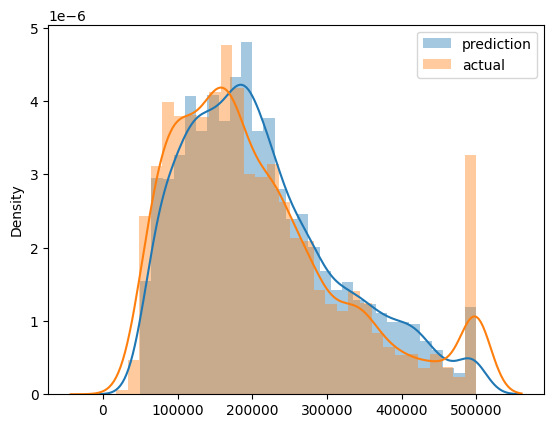

In [87]:
sns.distplot(best_y_pred, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()

In [ ]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse =mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
df.columns